# Problem

The data set consists of records of customers review regarding Alexa. Each customer's review has been categorized into **Postive** and **Negative** based on the reviews given.

# Objective

The objective of this analysis is ,build a predictive classification model on text data highly processed by spaCy and predict future instances.

# Import Packages

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Dataset

In [2]:
!wget https://www.dropbox.com/s/ynr03grbps6yy4a/amazon_alexa.tsv

--2020-09-06 11:08:02--  https://www.dropbox.com/s/ynr03grbps6yy4a/amazon_alexa.tsv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ynr03grbps6yy4a/amazon_alexa.tsv [following]
--2020-09-06 11:08:02--  https://www.dropbox.com/s/raw/ynr03grbps6yy4a/amazon_alexa.tsv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9129e544b03af30ff5270d56a5.dl.dropboxusercontent.com/cd/0/inline/A-0HTs_y53OG17AuX6Dm5TI5ss-RvOJU3KyAjc4mZzmYoVMG_bqkovFum_xVykFRX1vQ35QEJfOMmAs6IMrL8da0YbYdF2Y5ga7ko5jHwa9qag/file# [following]
--2020-09-06 11:08:03--  https://uc9129e544b03af30ff5270d56a5.dl.dropboxusercontent.com/cd/0/inline/A-0HTs_y53OG17AuX6Dm5TI5ss-RvOJU3KyAjc4mZzmYoVMG_bqkovFum_xVykFRX1vQ35QEJfOMmAs6IMrL8da0YbYdF2Y5ga7ko5jHwa9qag/file
Resolvi

# Read The Data

In [3]:
df_amazon = pd.read_csv("amazon_alexa.tsv", sep = "\t")

In [4]:
df_amazon.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
df_amazon.shape

(3150, 5)

In [6]:
df_amazon.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

# Tokenization

In [7]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

# Custom Transformer

To further clean our text data, we’ll also want to create a custom transformer for removing initial and end spaces and converting text into lower case.

In [8]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Vectorization

We need to perform feature vectorization in order to transform word tokens into numbers. We can do it using tf-idf ,Bag of Words. During modeling the data we will use any one of the two feature vectorization techniques.

In [9]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [10]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

# Data Preparation(Train_Test_Split)

In [11]:
from sklearn.model_selection import train_test_split

X = df_amazon['verified_reviews'] # the features we want to analyze
ylabels = df_amazon['feedback'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

# Pipeline

We will use pipeline to integrate the entire modeling technique at one time . In this we also we explore the concept of parameter tuning using GridSearchCV

###Pipeline 1

Decision Tree model with GridSearchCV

In [12]:
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(class_weight='balanced')
from sklearn.model_selection import GridSearchCV
parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf=GridSearchCV(classifier,parameters)

In [13]:

# Create pipeline using tf-idf
pipe1 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', clf)])

# model generation
pipe1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f864e036e10>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                                               min_weight_fraction_leaf=0.0,
  

###Pipeline2

Pipeline without GridesearchCV

In [14]:
# Create pipeline using tf-idf
pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f864e036438>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                   

# Evaluation

**Evaluation of GridSearchCV Decision Tree model**

In [15]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe1.predict(X_test)

# Model Accuracy
print(" Accuracy:",metrics.accuracy_score(y_test, predicted))
print(" Precision:",metrics.precision_score(y_test, predicted))
print(" Recall:",metrics.recall_score(y_test, predicted))

 Accuracy: 0.725925925925926
 Precision: 0.9744
 Recall: 0.7147887323943662


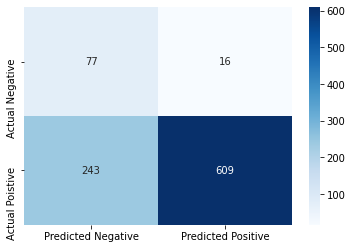

In [16]:
cfm=metrics.confusion_matrix(y_test, predicted)
lbl1=["Predicted Negative", "Predicted Positive"]
lbl2=["Actual Negative", "Actual Poistive"]
sns.heatmap(cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

**Evaluation of simple Decision Tree model**

 Accuracy: 0.870899470899471
 Precision: 0.9517326732673267
 Recall: 0.9025821596244131


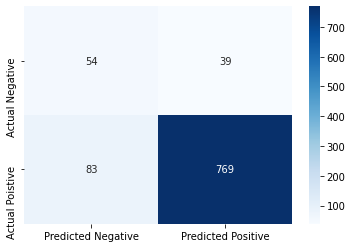

In [17]:
# Predicting with a test dataset
predicted2 = pipe2.predict(X_test)

# Model Accuracy
print(" Accuracy:",metrics.accuracy_score(y_test, predicted2))
print(" Precision:",metrics.precision_score(y_test, predicted2))
print(" Recall:",metrics.recall_score(y_test, predicted2))
cfm2=metrics.confusion_matrix(y_test, predicted2)
lbl1=["Predicted Negative", "Predicted Positive"]
lbl2=["Actual Negative", "Actual Poistive"]
sns.heatmap(cfm2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()